ADF Test for Tesla Stock Prices:
ADF Statistic: -1.815638632954844
p-value: 0.37272565127647195
Critical Values:
   1%: -3.4334947554105537
   5%: -2.862929213668854
   10%: -2.567509552921939


Checking for missing or infinite values in the differenced data and exogenous variables:
Close_Tesla_diff    0
Close_SP500         0
Daily Revenue       0
dtype: int64
Close_Tesla_diff    0
Close_SP500         0
Daily Revenue       0
dtype: int64


C:\Users\phamp\AppData\Local\Temp\ipykernel_27216\2993972264.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Close_Tesla_diff'] = train_data['Close_Tesla'].diff()
C:\Users\phamp\AppData\Local\Temp\ipykernel_27216\2993972264.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.dropna(subset=['Close_Tesla_diff'], inplace=True)
C:\Users\phamp\AppData\Local\Temp\ipykernel_27216\2993972264.py:54: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(train_data[['Close_Tesla_diff', 'Close_SP500', 'Daily Re

                                     SARIMAX Results                                      
Dep. Variable:                   Close_Tesla_diff   No. Observations:                 2096
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -6579.622
Date:                            Thu, 14 Nov 2024   AIC                          13171.244
Time:                                    15:22:32   BIC                          13205.093
Sample:                                01-03-2019   HQIC                         13183.647
                                     - 09-28-2024                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Close_SP500       0.0017      0.000      3.649      0.000       0.001       0.003
Daily Revenue     0.1410  

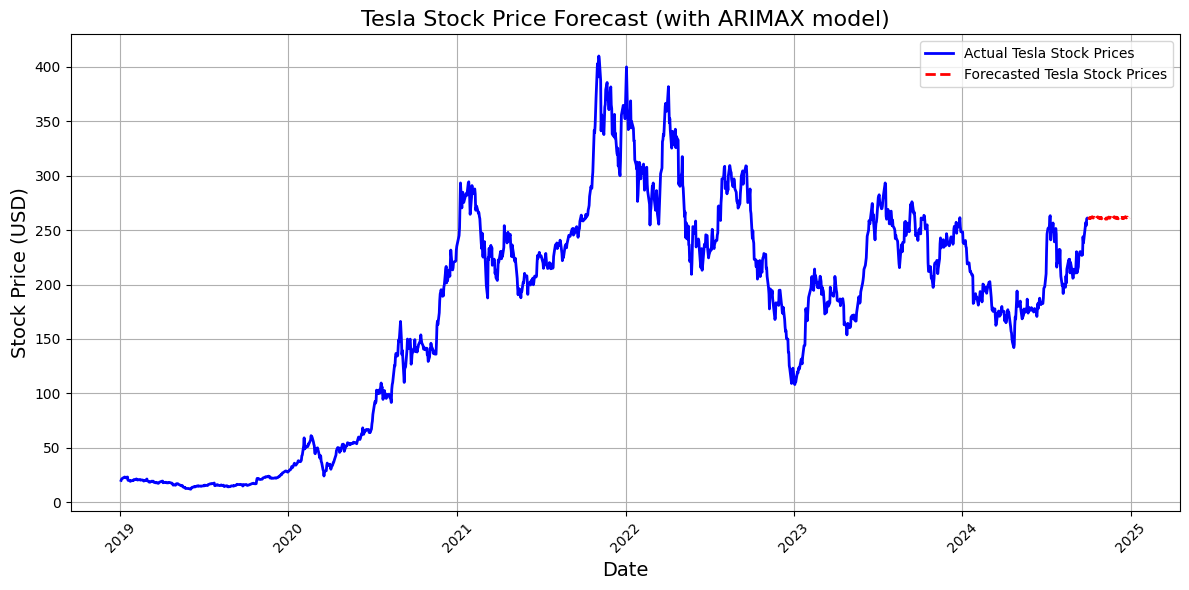

In [12]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from datetime import timedelta

# Load the data files
tesla_file_path = 'filled_Tesla_Close_2019_2024.csv'
sp500_file_path = 'filled_S&P500_Close_2019_2024.csv'
revenue_file_path = 'Daily_Revenue_2019_2024.csv'

tesla_stock = pd.read_csv(tesla_file_path)
sp500_stock = pd.read_csv(sp500_file_path)
revenue_data = pd.read_csv(revenue_file_path)

# Preprocess the data for Tesla stock, S&P 500, and Daily Revenue
tesla_stock['Date'] = pd.to_datetime(tesla_stock['Date'])
sp500_stock['Date'] = pd.to_datetime(sp500_stock['Date'])
revenue_data['Date'] = pd.to_datetime(revenue_data['Date'])

# Merging the three datasets on 'Date' column
merged_data = pd.merge(tesla_stock, sp500_stock, on='Date', suffixes=('_Tesla', '_SP500'))
merged_data = pd.merge(merged_data, revenue_data, on='Date')

# Set Date as the index
merged_data.set_index('Date', inplace=True)

# Filter data up to 30th September 2024 for training
train_data = merged_data.loc['2019-01-01':'2024-09-30']

# Check stationarity using Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    print("\n")

# Perform ADF test on Tesla stock prices
print("ADF Test for Tesla Stock Prices:")
adf_test(train_data['Close_Tesla'])

# If series is not stationary, take first difference
train_data['Close_Tesla_diff'] = train_data['Close_Tesla'].diff()

# Drop NaN values created by differencing
train_data.dropna(subset=['Close_Tesla_diff'], inplace=True)

# Check for NaN or infinite values in the differenced data and exogenous variables
print("Checking for missing or infinite values in the differenced data and exogenous variables:")
print(train_data[['Close_Tesla_diff', 'Close_SP500', 'Daily Revenue']].isna().sum())  # Check NaN values
print(train_data[['Close_Tesla_diff', 'Close_SP500', 'Daily Revenue']].applymap(lambda x: x == float('inf')).sum())  # Check Inf values

# Drop any remaining rows with NaN or Inf values
train_data = train_data.dropna(subset=['Close_Tesla_diff', 'Close_SP500', 'Daily Revenue'])
train_data = train_data[~train_data[['Close_Tesla_diff', 'Close_SP500', 'Daily Revenue']].applymap(lambda x: x == float('inf')).any(axis=1)]

# Prepare the data for ARIMAX: Tesla stock 'Close' as the target,
# S&P 500 'Close' and Daily Revenue as the exogenous variables
X_train = train_data[['Close_SP500', 'Daily Revenue']]  # Exogenous variables: S&P 500 and Daily Revenue
y_train = train_data['Close_Tesla_diff']  # Dependent variable (differenced data)

# Fit the ARIMAX model
model = sm.tsa.SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
results = model.fit()

# Display the summary of the ARIMAX model
print(results.summary())

# Now forecast the next 90 days starting from 1st October 2024
forecast_steps = 90
forecast_index = pd.date_range('2024-10-01', periods=forecast_steps, freq='D')

# Use the most recent exogenous values to forecast
forecast_exog = merged_data[['Close_SP500', 'Daily Revenue']].iloc[-forecast_steps:]  # Last available exogenous data

# Forecast using the ARIMAX model
forecast = results.get_forecast(steps=forecast_steps, exog=forecast_exog)

# Plotting the actual and forecasted Tesla stock prices
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Close_Tesla'], label='Actual Tesla Stock Prices', color='blue', linewidth=2)
plt.plot(forecast_index, forecast.predicted_mean + train_data['Close_Tesla'].iloc[-1], label='Forecasted Tesla Stock Prices', color='red', linestyle='--', linewidth=2)

# Add labels and title
plt.title('Tesla Stock Price Forecast (with ARIMAX model)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price (USD)', fontsize=14)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Display the legend
plt.legend()

# Display the grid
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
